In [4]:
import train
import time
import os

from analysis import performance

import matplotlib.pyplot as plt
import tools
import numpy as np
from task import generate_trials, rule_name, get_dist
%load_ext autoreload
%autoreload 2


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3813845439215246835
]


In [4]:


rules_pairs = [
    ['contextdm1', 'contextdm2'],
    ['delaydm1', 'dm1'],
    ['dm1', 'contextdm1'],
    ['dmcgo', 'dmcnogo'],
    ['fdanti', 'dm1']
]

for rules in rules_pairs:
    rules_str = "_".join(rules)
    model_dir = os.path.join('laconeu_test_16_units', rules_str) #A folder for each pair
    
    start_time = time.time() 
    
    train.train(
        model_dir=model_dir,  
        hp={
            'learning_rate': 0.001,
            'n_rnn': 16,
            'rule_strength': 1.0,
            'no_rule': False,
            'target_perf': 0.8,
            'activation': 'softplus',
            'alpha': 0.2
        },
        ruleset='all',
        rule_trains=rules,
        trainables='all'
    )
    
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    print('Training for rules:', rules, 'time:', elapsed_seconds)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(101, 16) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(16, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
use_separate_input   = False
loss_type            = lsq
optimizer            = adam
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
l1_h                 = 0
l2_h                 = 0
l1_weight            = 0
l2_weight            = 0
l2_weight_init       = 0
p_weight_train       = None
target_perf          = 0.8
n_eachring           = 32
num_ring             = 2
n_rule               = 20
rule_start           = 65
n_input     

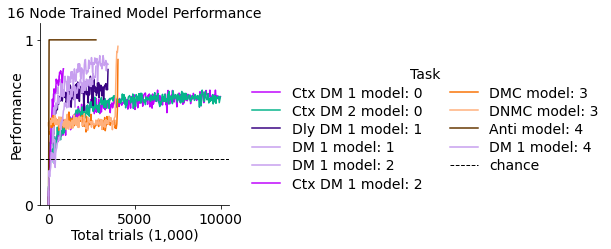

In [11]:
_rule_color = {
    'reactgo': 'green',
            'delaygo': 'olive',
            'fdgo': 'forest green',
            'reactanti': 'mustard',
            'delayanti': 'tan',
            'fdanti': 'brown',
            'dm1': 'lavender',
            'dm2': 'aqua',
            'contextdm1': 'bright purple',
            'contextdm2': 'green blue',
            'multidm': 'blue',
            'delaydm1': 'indigo',
            'delaydm2': 'grey blue',
            'contextdelaydm1': 'royal purple',
            'contextdelaydm2': 'dark cyan',
            'multidelaydm': 'royal blue',
            'dmsgo': 'red',
            'dmsnogo': 'rose',
            'dmcgo': 'orange',
            'dmcnogo': 'peach'
            }

dm_family = ['dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm']
go_family = ['reactgo', 'delaygo', 'fdgo', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
anti_family = ['reactanti', 'delayanti', 'fdanti']

rule_color = {k: 'xkcd:'+v for k, v in _rule_color.items()}

def plot_performanceprogress(model_dirs, title=None):

    fs = 14 # fontsize
    w = 7.5
    h = 4.2
    transparent = False

    fig = plt.figure(figsize=(w,h))
    ax = fig.add_axes([0.1,0.25,0.35,0.6])
    lines = list()
    labels = list()

    rules = []
    x_plots = []
    costs = []
    perfs = []
    model = []
    for i, model_dir in enumerate(model_dirs):
        # Plot Training Progress
        log = tools.load_log(model_dir)
        hp = tools.load_hp(model_dir)
        rules_mod = hp['rules']
        trials = log['trials']
        x_plot = np.array(trials)/1000.
        
        for rule in rules_mod:
            cost = np.log10(log['cost_'+rule])
            perf = log['perf_'+rule]
        
            rules.append(rule)
            x_plots.append(x_plot)
            costs.append(cost)
            perfs.append(perf)
            model.append(i)
            

    for i, rule in enumerate(rules):
        # line = ax1.plot(x_plot, np.log10(cost_tests[rule]),color=color_rules[i%26])
        # ax2.plot(x_plot, perf_tests[rule],color=color_rules[i%26])
        line = ax.plot(x_plots[i], costs[i],
                    color=rule_color[rule])
        ax.plot(x_plots[i], perfs[i], color=rule_color[rule])
        lines.append(line[0])
        label = rule_name[rule] + ' model: ' + str(model[i])
        labels.append(label)

    ax.tick_params(axis='both', which='major', labelsize=fs)
    line = ax.axhline(0.275, color='black', linestyle='--', linewidth=1.)
    lines.append(line)
    labels.append('chance')
    ax.set_ylim([0, 1.1])
    ax.set_xlabel('Total trials (1,000)',fontsize=fs, labelpad=2)
    ax.set_ylabel('Performance',fontsize=fs, labelpad=0)
    ax.locator_params(axis='x', nbins=3)
    ax.set_yticks([0,1])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    if title is not None:
        ax.set_title(title,fontsize=fs)
    lg = fig.legend(lines, labels, title='Task',ncol=2,bbox_to_anchor=(0.47,0.5),
                    fontsize=fs,labelspacing=0.3,loc=6,frameon=False)
    plt.setp(lg.get_title(),fontsize=fs)
    # sfn = model_dir + '/figure/Performance_Progress'
    # plt.savefig(sfn, transparent=transparent)
    plt.show()

#get list of all file names with retrain_rnnbias_outputweights
import os

# model_dirs = ['retrain_rnnbias_outputweights_contextdm1',
#                'retrain_rnnbias_outputweights_contextdm2', 
#                'retrain_rnnbias_outputweights_multidm',
#                'retrain_rnnbias_outputweights_delaydm1',
#                'retrain_rnnbias_outputweights_delaydm2',
#                'retrain_rnnbias_outputweights_reactgo',
#                'retrain_rnnbias_outputweights_fdgo',
#                'retrain_rnnbias_outputweights_dmsgo',
#                'retrain_rnnbias_outputweights_dmcgo',
#                'train_all_params_contextdelaydm1']

#split model dirs into those that conntain
#dm, go, and anti
# dm_dirs = [d for d in model_dirs if d.split('_')[-1] in dm_family]
# go_dirs = [d for d in model_dirs if d.split('_')[-1] in go_family]
# anti_dirs = [d for d in model_dirs if d.split('_')[-1] in anti_family]

# plot_performanceprogress(dm_dirs, title='DM Family')
# plot_performanceprogress(go_dirs, title='GO Family')
# plot_performanceprogress(anti_dirs, title='ANTI Family')

model_dirs = [
    'laconeu_test_16_units/contextdm1_contextdm2',
    'laconeu_test_16_units/delaydm1_dm1',
    'laconeu_test_16_units/dm1_contextdm1',
    'laconeu_test_16_units/dmcgo_dmcnogo',
    'laconeu_test_16_units/fdanti_dm1'
]

#increase fig size
plt.rcParams['figure.figsize'] = [10, 10]

plot_performanceprogress(model_dirs, title='16 Node Trained Model Performance')